In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - chemistry_maps.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Make 2D chemistry maps of the nearby MW using the Gaia DR2 + AstroNN catalog
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, copy, math
from tqdm import tqdm_notebook

## Plotting
from matplotlib import pyplot as plt
from matplotlib import colors, cm

## Astropy
from astropy.io import fits
from astropy import table
from astropy import units as apu
from astropy.coordinates import CartesianDifferential

## Scipy
from scipy.stats import binned_statistic_2d

In [5]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rc('font', size=12)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Meta

## Future work

## Information

# Load
Load the precut AstroNN catalog and apply a cut on the galactocentric $Z$, then convert values to galactocentric coordinates and velocities.

In [6]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [7]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [9]:
### Read catalog values

# ID & kinematics
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

# Chemistry
c = data_low_z['C']
sc = data_low_z['C_ERROR']
n = data_low_z['N']
sn = data_low_z['N_ERROR']
na = data_low_z['NA']
sna = data_low_z['NA_ERROR']
mg = data_low_z['MG']
smg = data_low_z['MG_ERROR']
al = data_low_z['AL']
sal = data_low_z['AL_ERROR']
si = data_low_z['SI']
ssi = data_low_z['SI_ERROR']
ca = data_low_z['CA']
sca = data_low_z['CA_ERROR']
mn = data_low_z['MN']
smn = data_low_z['MN_ERROR']
fe = data_low_z['FE']
sfe = data_low_z['FE_ERROR']

In [10]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = -np.sin(gc_phi)*gc_vx + np.cos(gc_phi)*gc_vy

# Plot Abundances

## Prepare

In [31]:
### Function definitions

def chem_hist_gcxy(x, y, vals, vmin, vmax, low_N_mask, no_N_mask, cmap, ax, fig, stat):
    
    # Make the histogram using the supplied value and stat. Stat must be 
    # compatible with binned_statistic_2d, either 'median' or np.std
    hist, xedges, yedges, binid = binned_statistic_2d(x, y, values=vals, statistic=stat,
                                                      bins=n_bins, range=hist_range)
    
    # Plot the image. Rotate to account for histogram => plotting grid
    img = ax.imshow(np.rot90(hist), interpolation='nearest',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add the image masks. Assumes same geometry as hist.
    low_N_img = ax.imshow(low_N_mask, interpolation='nearest',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    no_N_img = ax.imshow(no_N_mask, interpolation='nearest',
                         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

    # Colorbar
    cbar = plt.colorbar(img, ax=ax)
    
    # Add the sun and it's orbit
    ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
    orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
    ax.add_artist(orbit_circle)
    
    # Decorate
    ax.set_xlabel(r'X$_{GC}$ [kpc]')
    ax.set_ylabel(r'Y$_{GC}$ [kpc]')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.tick_params(direction='in', top='on', right='on')
    
    return fig, ax, cbar
#def

# Calculate the mean of a logarithmic quantity
def log_mean(vals):
    if len(vals) <= 0:
        return 0
    else: 
        return np.log10( np.average( np.power( 10, vals ) ) )
    ##ie
#def

# Calculate the standard deviation of a logarithmic quantity
def log_std(vals):
    if len(vals) <= 1:
        return 0
    else:
        return np.log10( np.std( np.power( 10, vals ) ) )
    ##ie
#def

# Calculate the error on the mean of a logarithmic quantity
def log_mean_err(vals,vals_err):
    if len(vals) == 0:
        return 0
    else:
        vals_lin = np.power(10, vals)
        err_vals_lin = np.multiply( vals_err, vals_lin )/0.434
        err_tot_lin = np.sqrt( np.sum( np.square( err_vals_lin ) ) )/len(err_vals_lin)
        err_tot_log = 0.434*( err_tot_lin / np.average(vals_lin) )
        return err_tot_log
    ##ie
#def
    
# Calculate the error on the difference of two logarithmic quantities
def log_diff_err(vals1, vals2, vals_err1, vals_err2):
    if len(vals1) == 0:
        return 0
    else:
        vals_lin1 = np.power(10, vals1)
        vals_lin2 = np.power(10, vals2)
        vals_lin_com = np.power(10, (vals1-vals2) )
        err_vals_lin1 = np.multiply( vals_err1, vals_lin1 )/0.434
        err_vals_lin2 = np.multiply( vals_err2, vals_lin2 )/0.434
        err_tot_lin = np.sqrt( np.square( err_vals_lin1 ) + np.square( err_vals_lin2 ) )
        err_tot_log = 0.434*( err_tot_lin / vals_lin_com )
        return err_tot_log
    ##ie
#def

In [12]:
### Create metallicities
cn = c-n
nafe = na-fe
mgfe = mg-fe
alfe = al-fe
sife = si-fe
cafe = ca-fe
mnfe = mn-fe
camg = ca-mg
cfe = c-fe

scn = log_diff_err(c,n,sc,sn)
snafe = log_diff_err(na,fe,sna,sfe)
smgfe = log_diff_err(mg,fe,smg,sfe)
salfe = log_diff_err(al,fe,sal,sfe)
ssife = log_diff_err(si,fe,ssi,sfe)
scafe = log_diff_err(ca,fe,sca,sfe)
smnfe = log_diff_err(mn,fe,smn,sfe)
scamg = log_diff_err(ca,mg,sca,smg)
scfe = log_diff_err(c,fe,sc,sfe)

In [13]:
### Prepare for plotting

# Bins
n_bins = 25

# Sun
x_sun = -8.125

# Ranges
x_hi = 0
x_lo = -15
y_hi = 10
y_lo = -5
hist_range = [ [x_lo,x_hi], [y_lo,y_hi] ]

# Close existing plots
plt.close('all')

## Stellar density

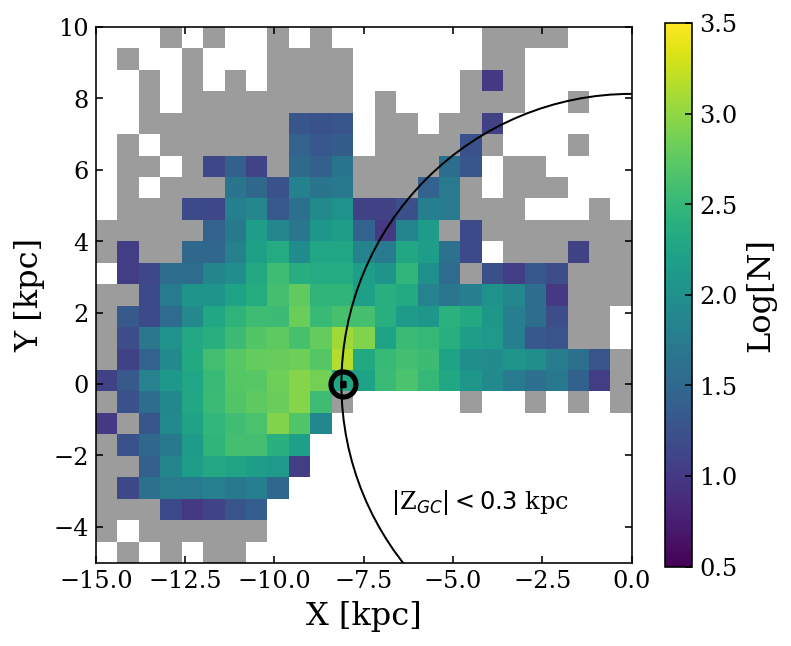

In [19]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

hist, xedges, yedges = np.histogram2d(gc_x, gc_y, bins=n_bins, range=hist_range)

# Rotate to account for histogram -> plotting grid
hist = np.rot90(hist)

# Find low-N bins. As long as histogram geometry remains the same this will be 
# used for greying out values.
where_low_N = np.where( (hist < 10) & (hist > 0) )
low_N_mask = np.zeros((n_bins,n_bins,4))
low_N_mask[:,:,3] = 0.0
low_N_mask[where_low_N[0],where_low_N[1],:3] = 100
low_N_mask[where_low_N[0],where_low_N[1],3] = 1.0

# Find 0-N bins. This will differentiate between no data and too little data
where_no_N = np.where( hist == 0 )
no_N_mask = np.zeros((n_bins,n_bins,4))
no_N_mask[:,:,3] = 0.0
no_N_mask[where_no_N[0],where_no_N[1],:3] = 1
no_N_mask[where_no_N[0],where_no_N[1],3] = 1.0

img = ax.imshow(np.ma.log10( hist ).filled(0), interpolation='nearest',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='viridis', vmin=0.5, vmax=3.5)
low_N_img = ax.imshow(low_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
no_N_img = ax.imshow(no_N_mask, interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

cbar = plt.colorbar(img, ax=ax)
ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
ax.add_artist(orbit_circle)

ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
cbar.set_label('Log[N]')
ax.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')

plt.show()
fig.savefig('plots/N_hist.pdf')
plt.close(fig)

# No output
pass;

### Figure 1
Number density of stars in the AstroNN sample with $|Z|<0.3$ kpc. The black circle shows galactocentric radius of 8 kpc and the black circle is the sun.

## Chemistry Maps

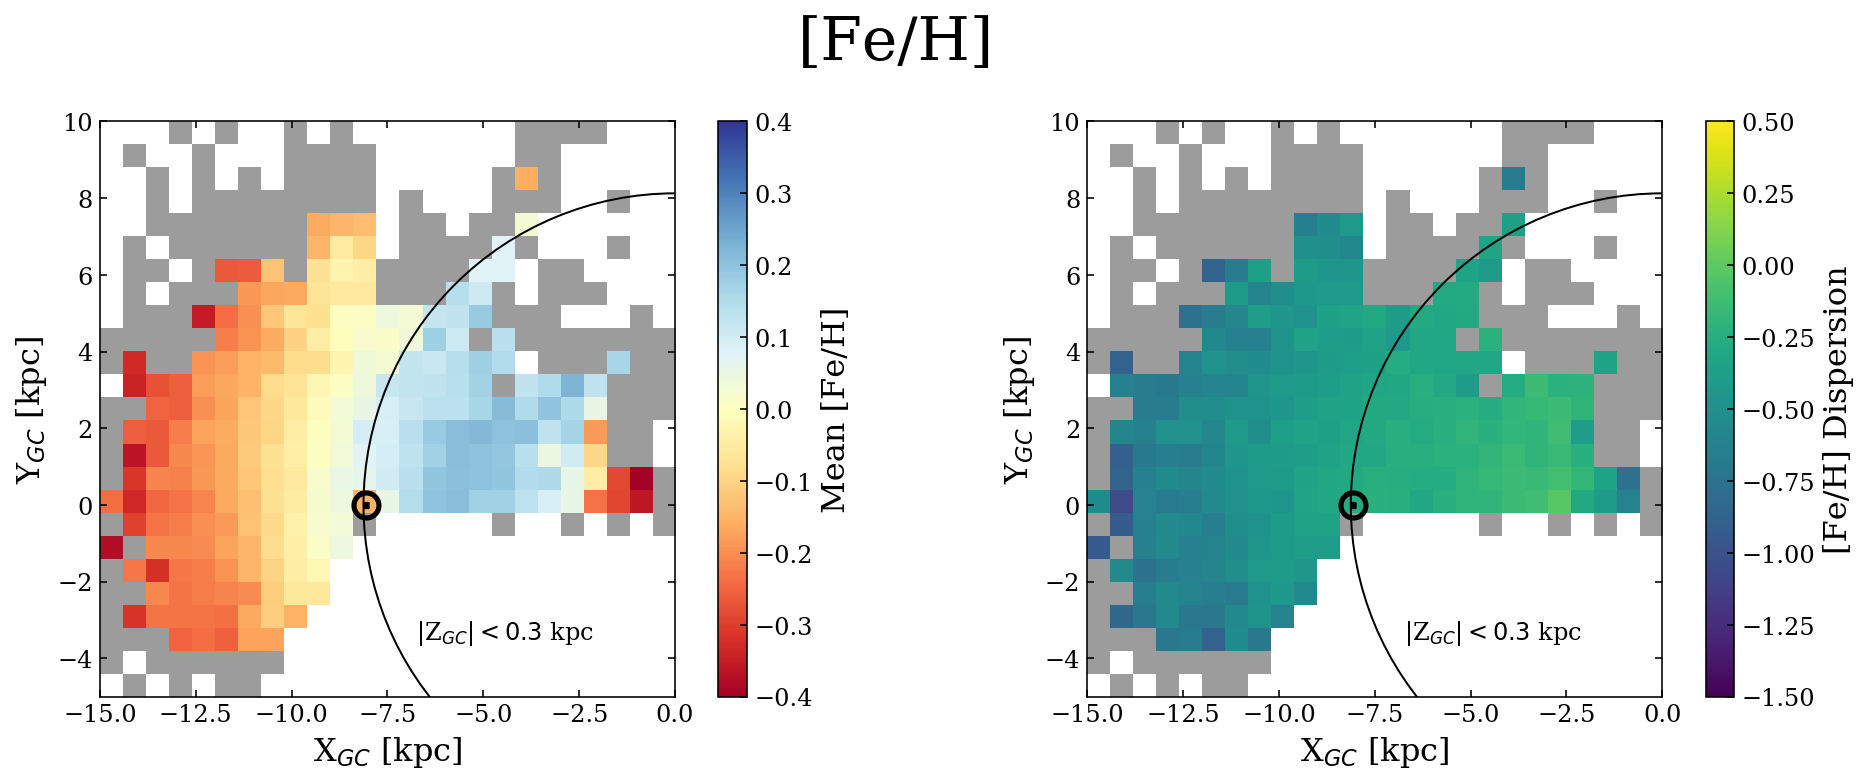

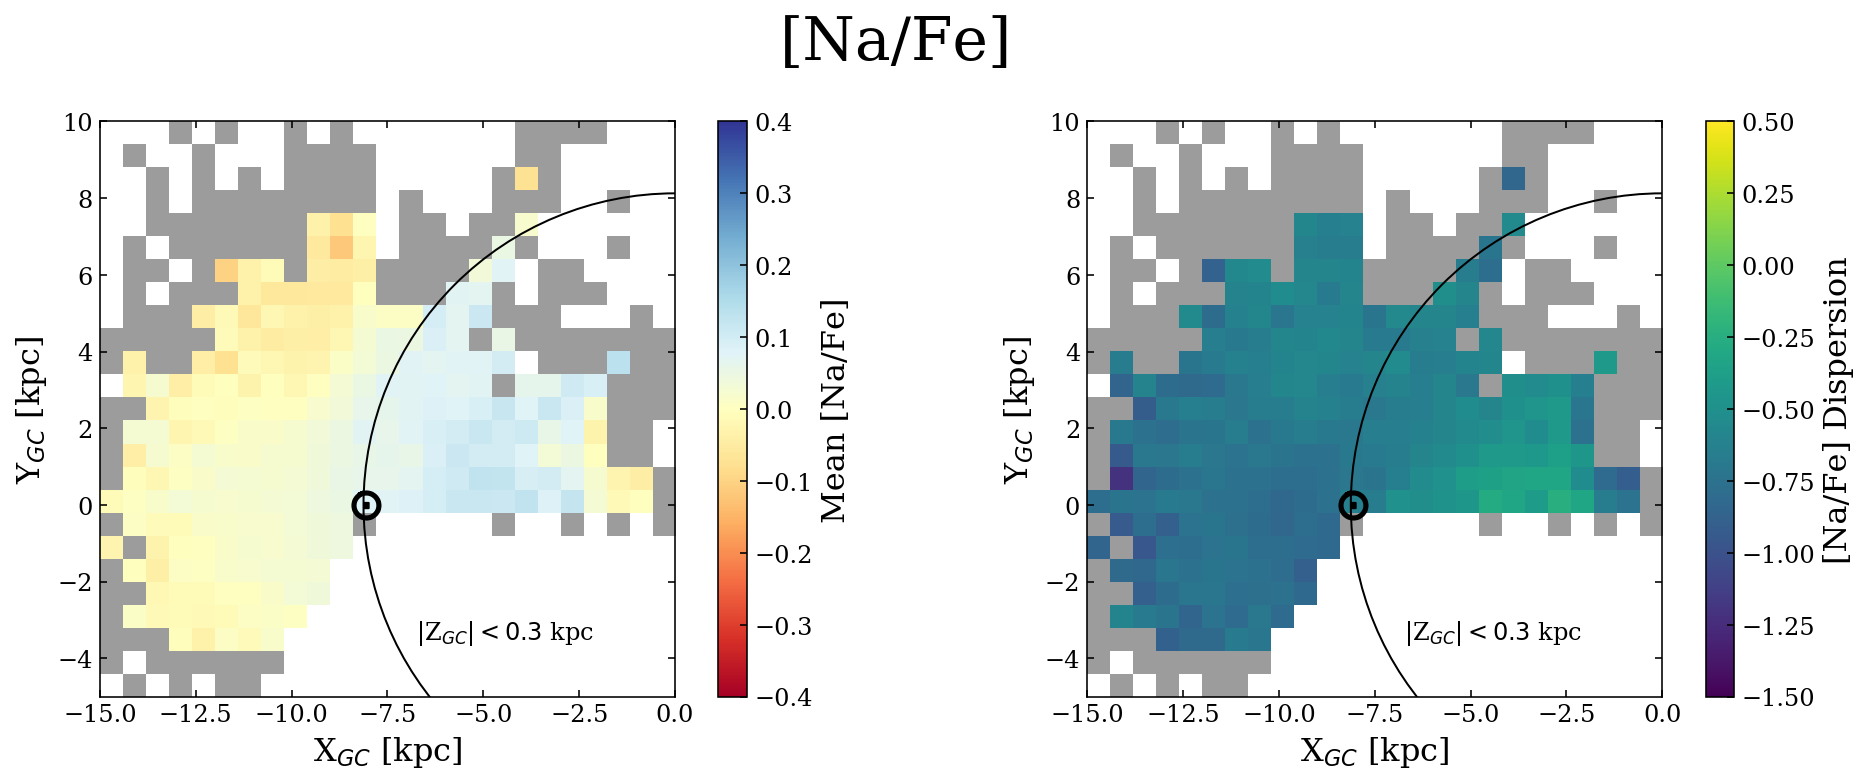

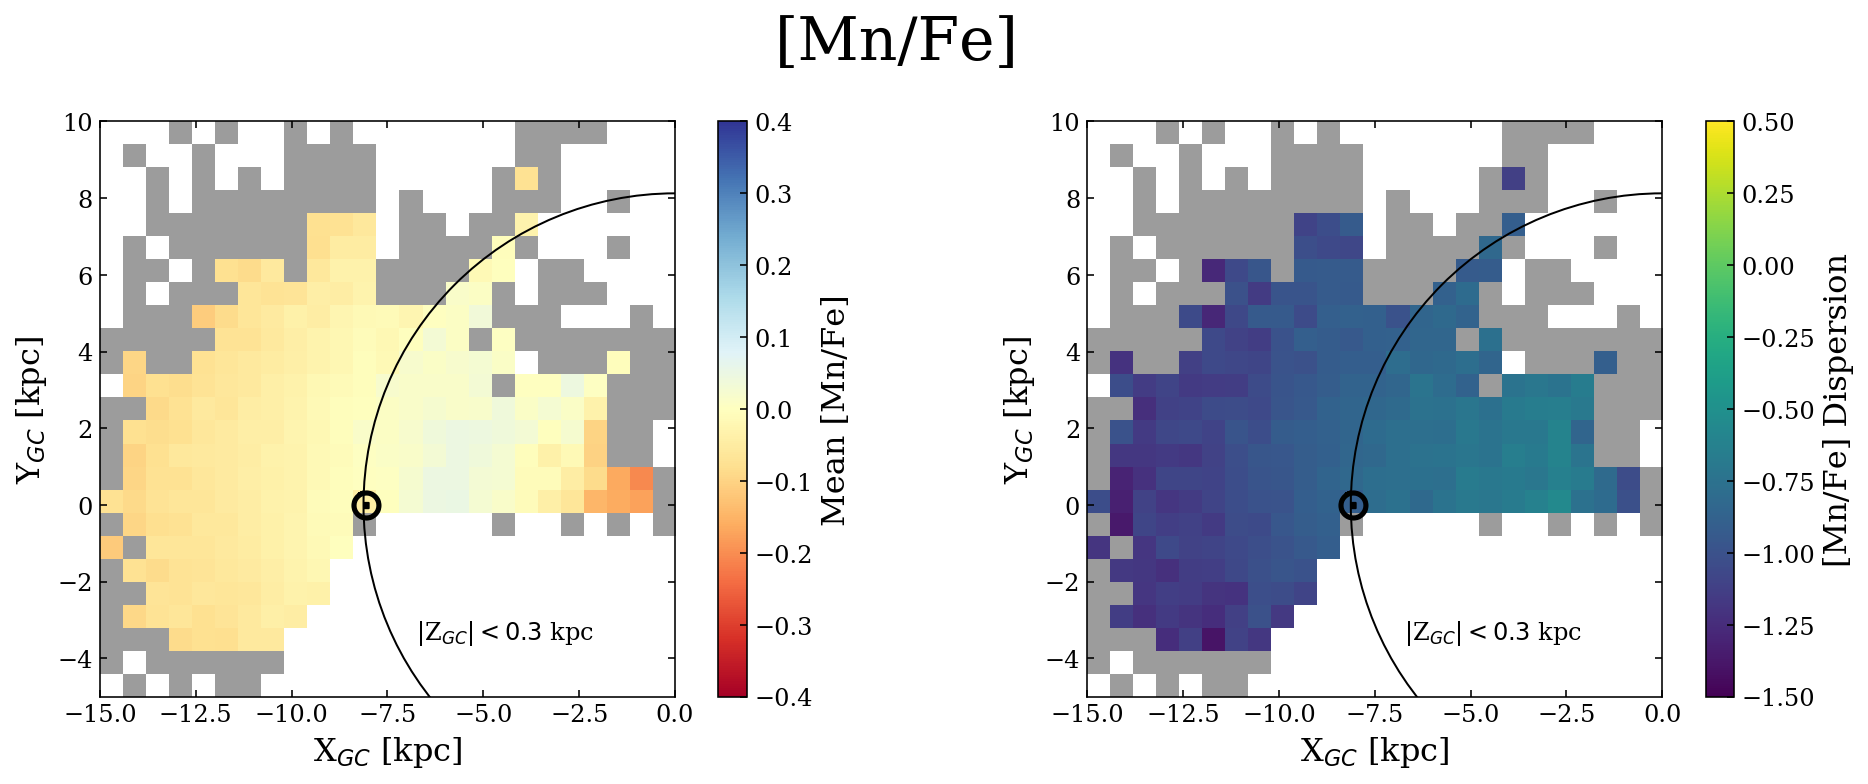

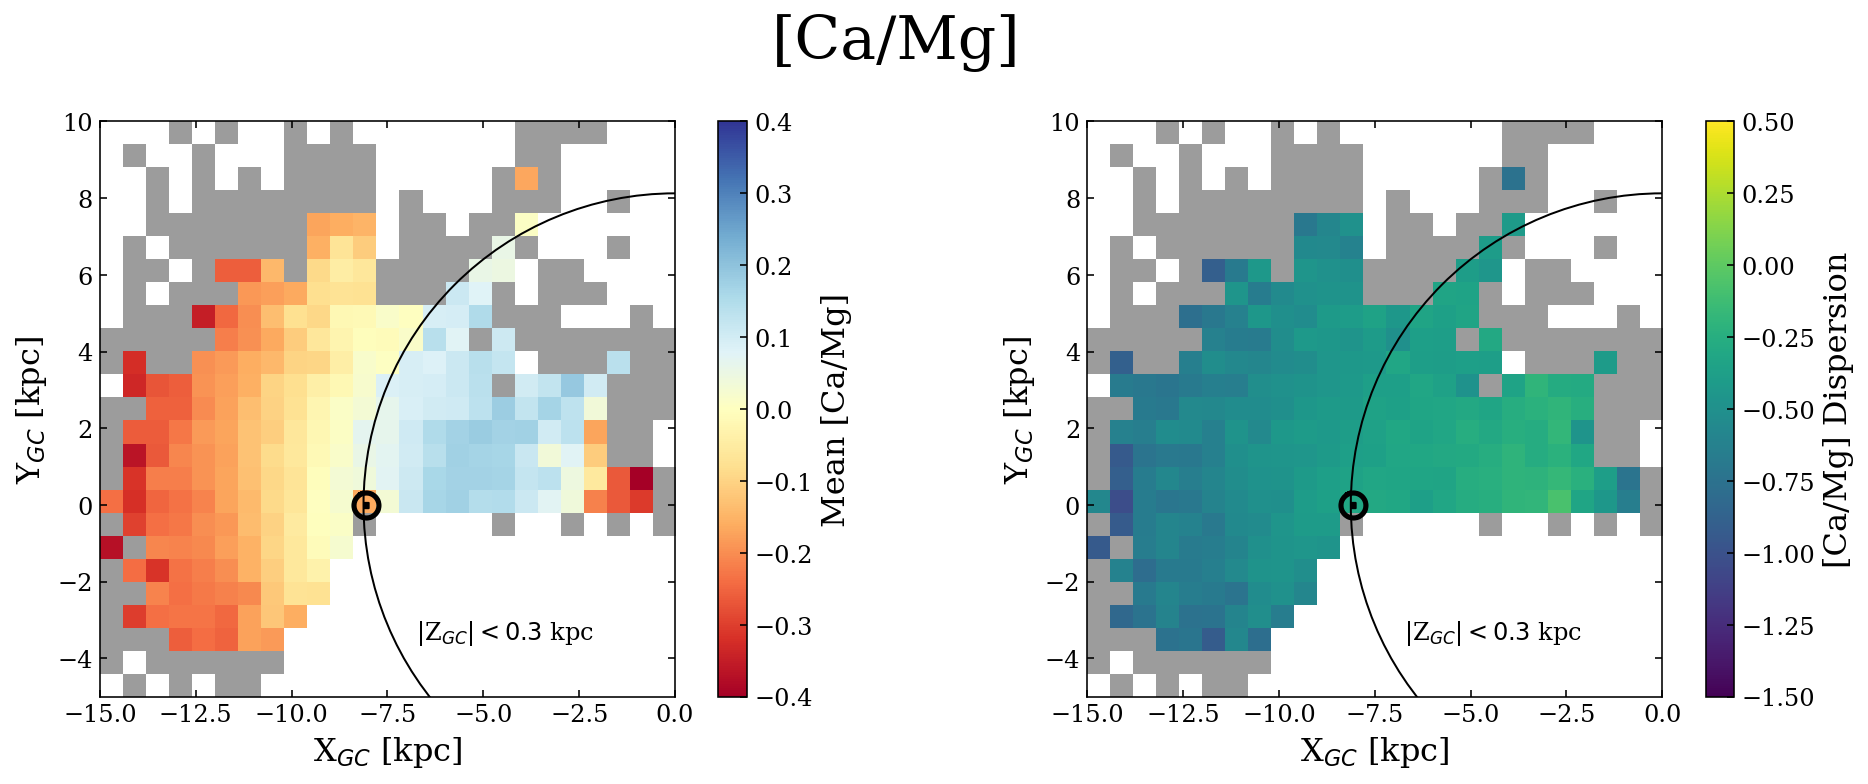

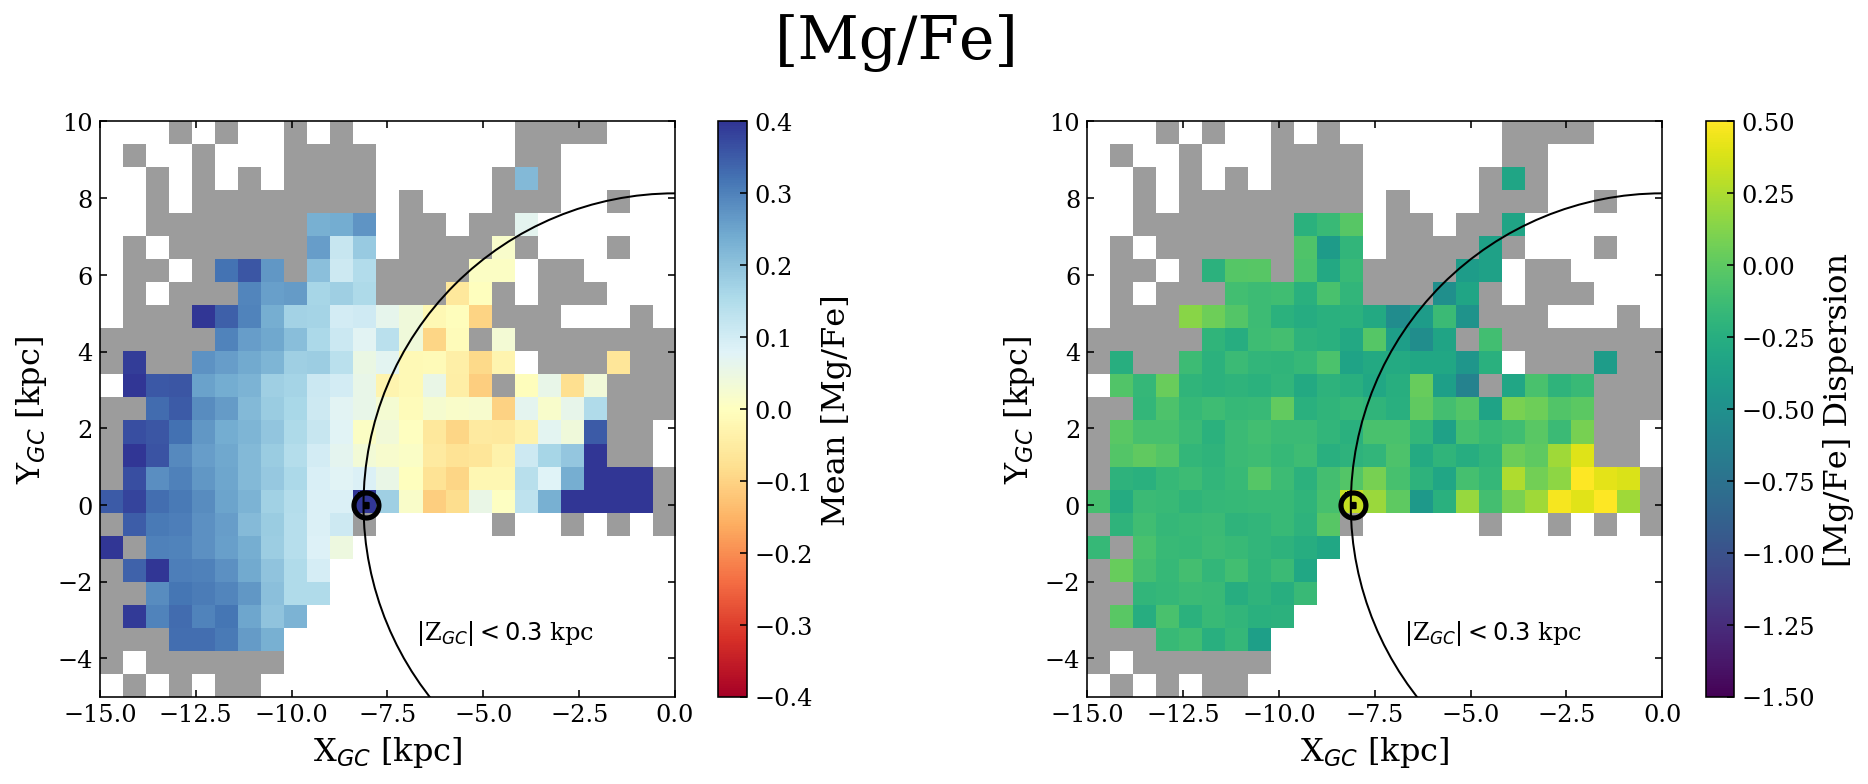

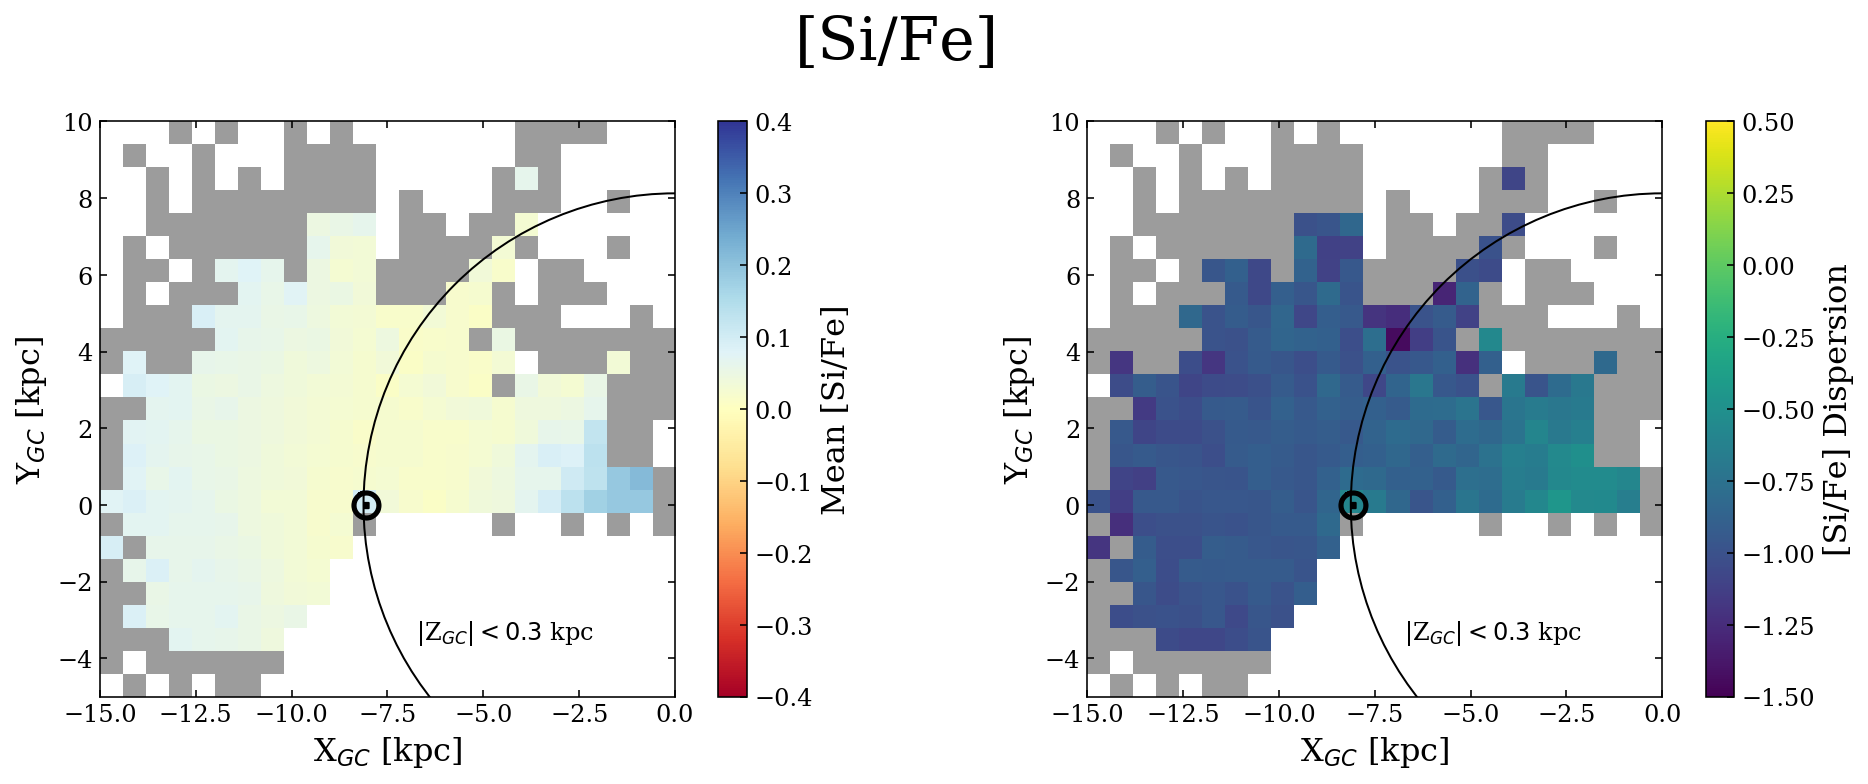

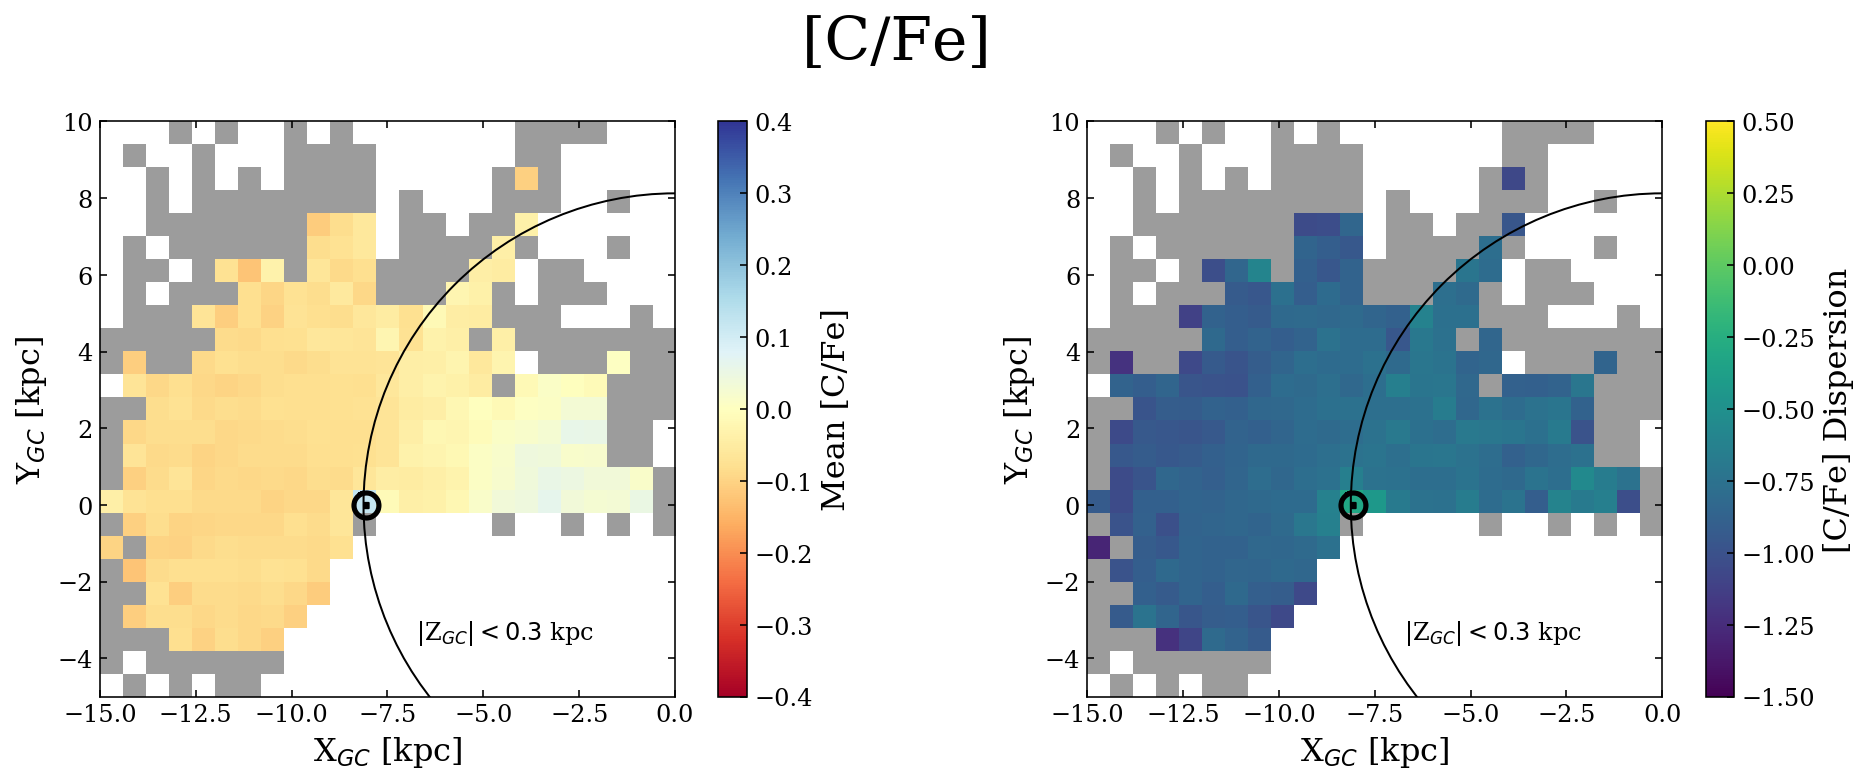

In [42]:
### Make the figure

chems = np.array([     fe  , nafe , mnfe , camg , mgfe  , sife , cfe   ])
chem_errs = np.array([ sfe , snafe, smnfe, scamg, smgfe , ssife, scfe  ])
chem_mins = np.array([ -0.4, -0.1 , -0.1, -0.3  , -0.4 , -0.4  , -0.4])
chem_maxs = np.array([ 0.4 , 0.1  , 0.1 , 0.3   , 0.4  , 0.4   , 0.4])
schem_mins = np.array([  -1,   -1 ,   -1 ,  -1  , -0.5  , -0.6 , -1])
schem_maxs = np.array([0.2 ,  0.0 , 0.0  , 0.1  , 0.5   ,  0.  , 0.5])
chem_names = np.array(['[Fe/H]','[Na/Fe]','[Mn/Fe]','[Ca/Mg]','[Mg/Fe]','[Si/Fe]','[C/Fe]'])

for i in range(len(chems)):
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    fig, ax1, cbar1 = chem_hist_gcxy(gc_x, gc_y, chems[i], -0.4, 0.4, low_N_mask, 
                                       no_N_mask, 'RdYlBu', ax1, fig, stat=log_avg)
    cbar1.set_label(r'Mean '+chem_names[i])
    ax1.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')  

    fig, ax2, cbar2 = chem_hist_gcxy(gc_x, gc_y, chems[i], -1.5, 0.5, low_N_mask, 
                                       no_N_mask, 'viridis', ax2, fig, stat=log_std)
    cbar2.set_label(chem_names[i]+' Dispersion')
    ax2.annotate(z_select_text, xy=(0.55,0.1), xycoords='axes fraction')
    
    fig.suptitle(chem_names[i], fontsize=30, y=1.1)
    plt.tight_layout()
    plt.show()
    plt.close('all')
###i

# No output
pass;

### Figure 2
Averages (left) and sample standard deviation (right) of 5 elemental abundances. Abundance errors are not taken into account for the right-hand plot, just the standard deviation of the sample is presented.

# Plot Average in Spatial Bins

/Users/JamesLane/Software/Python/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


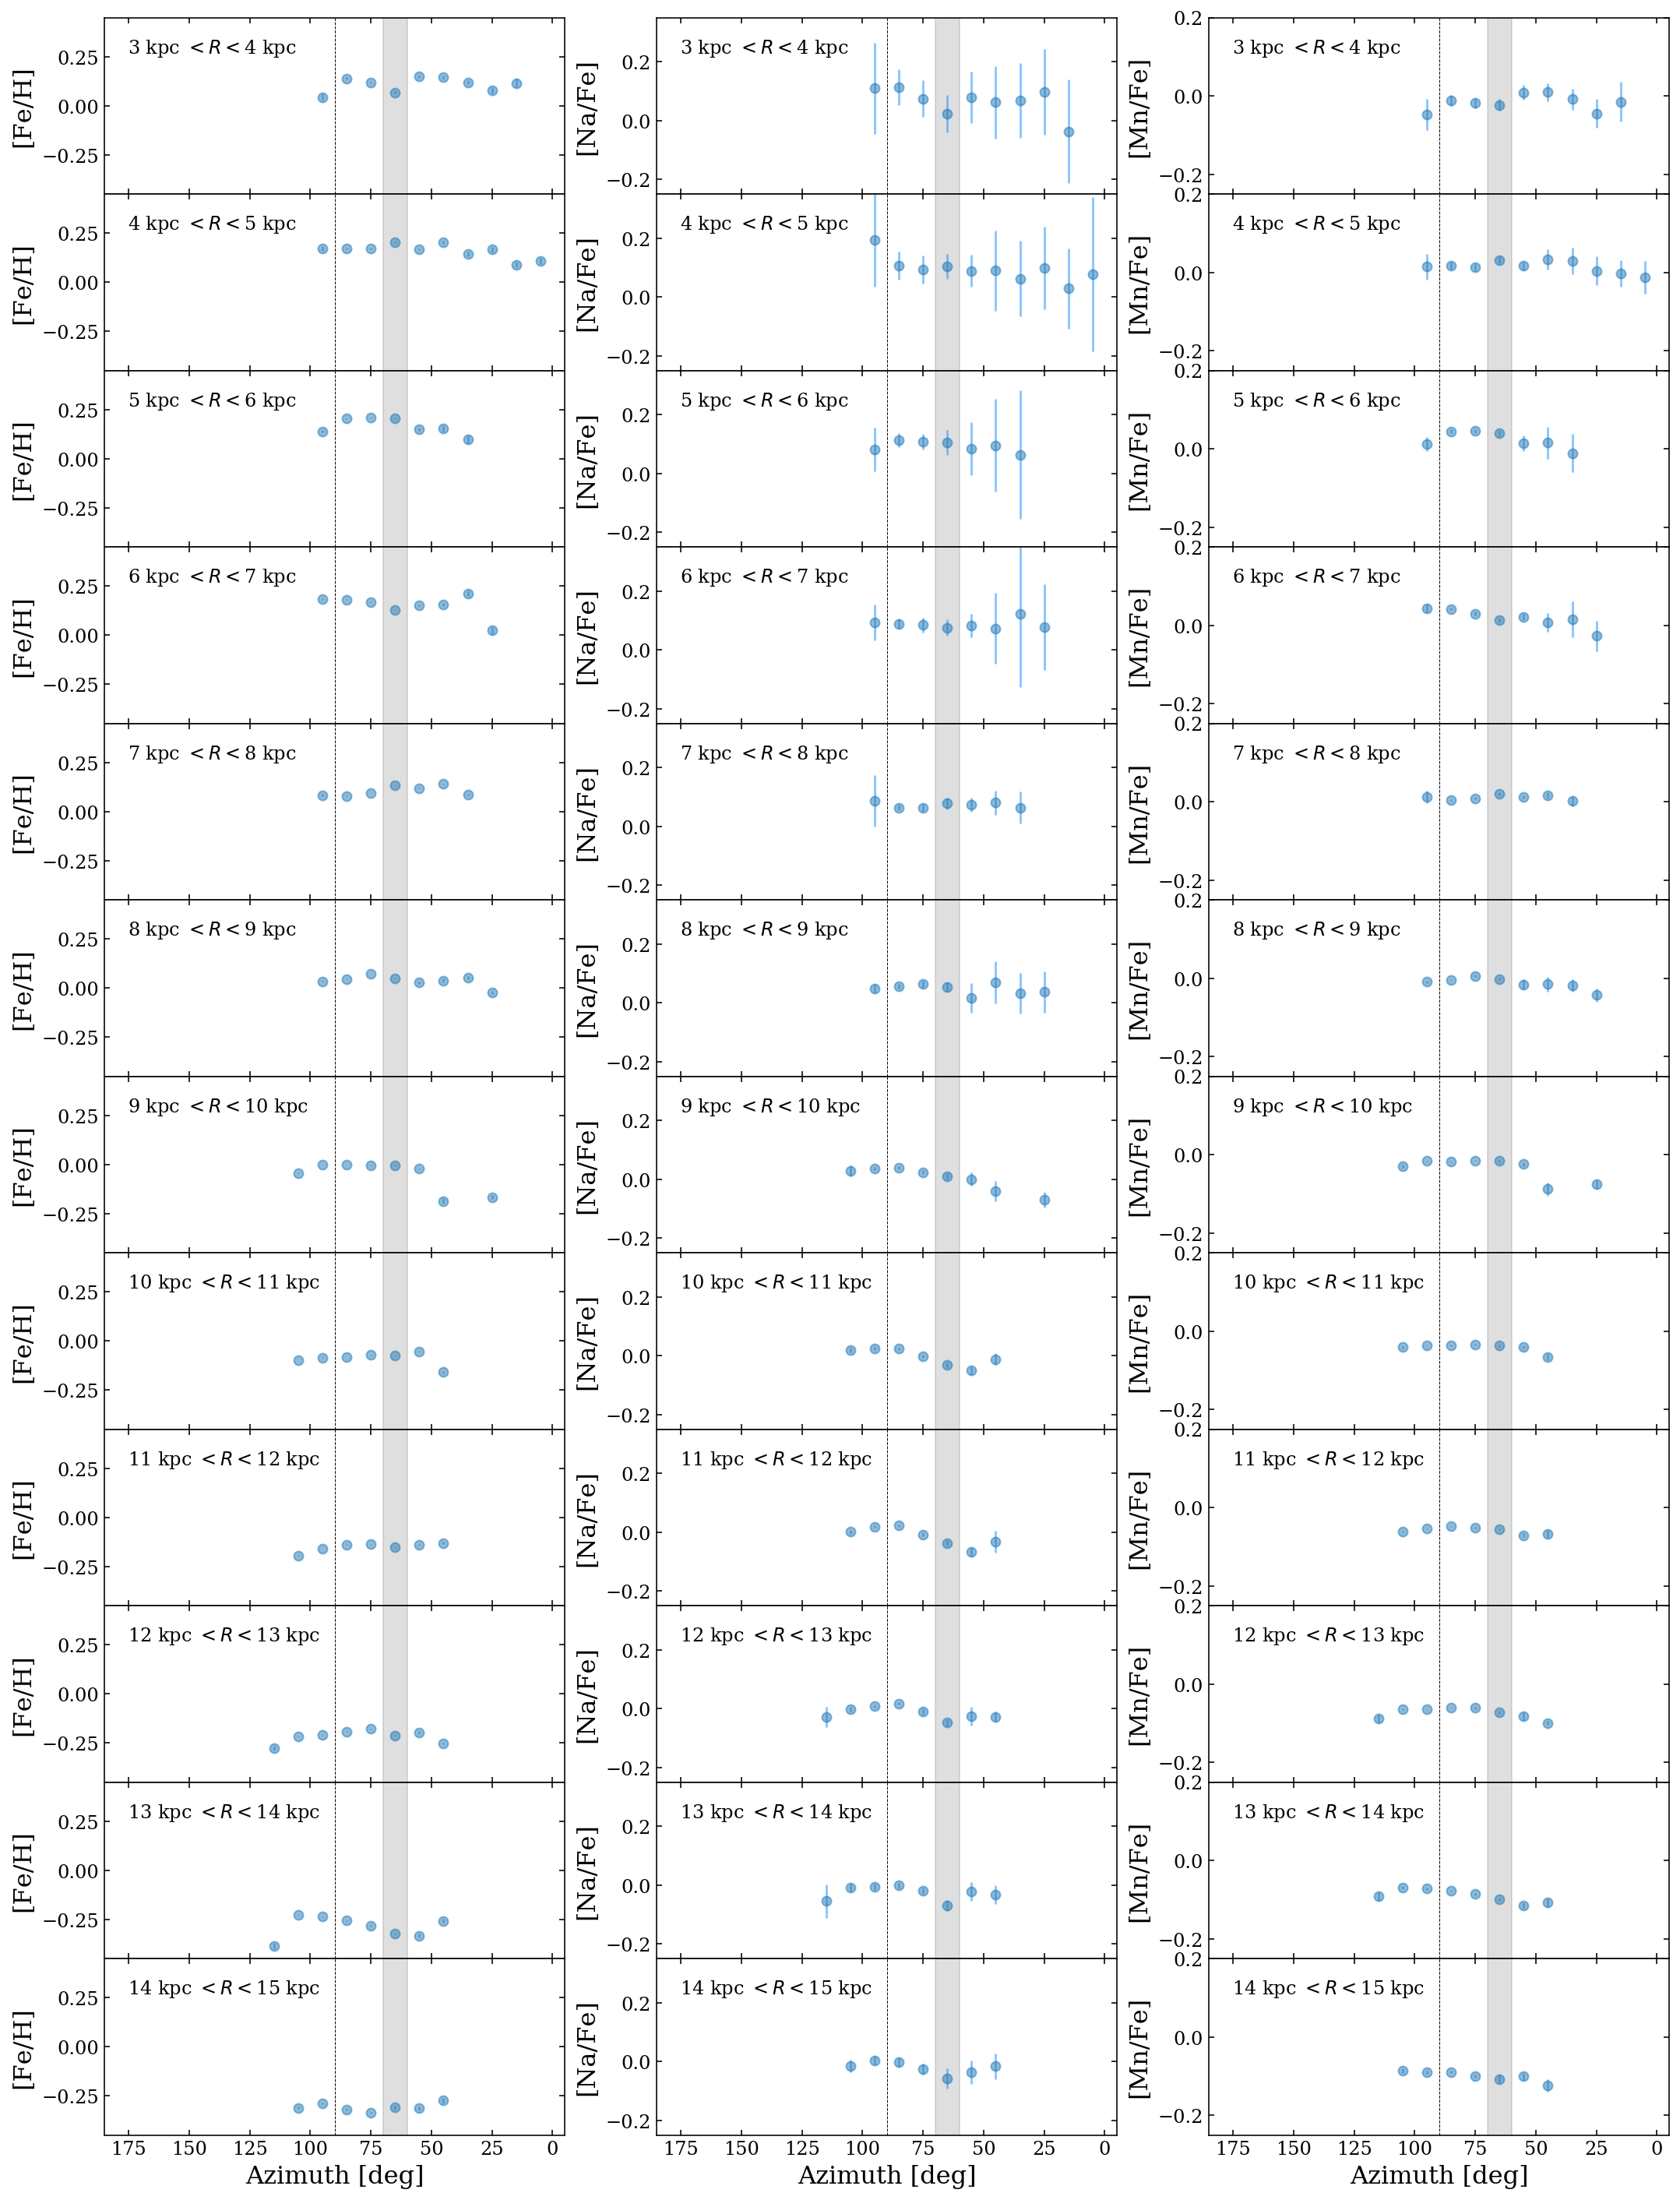

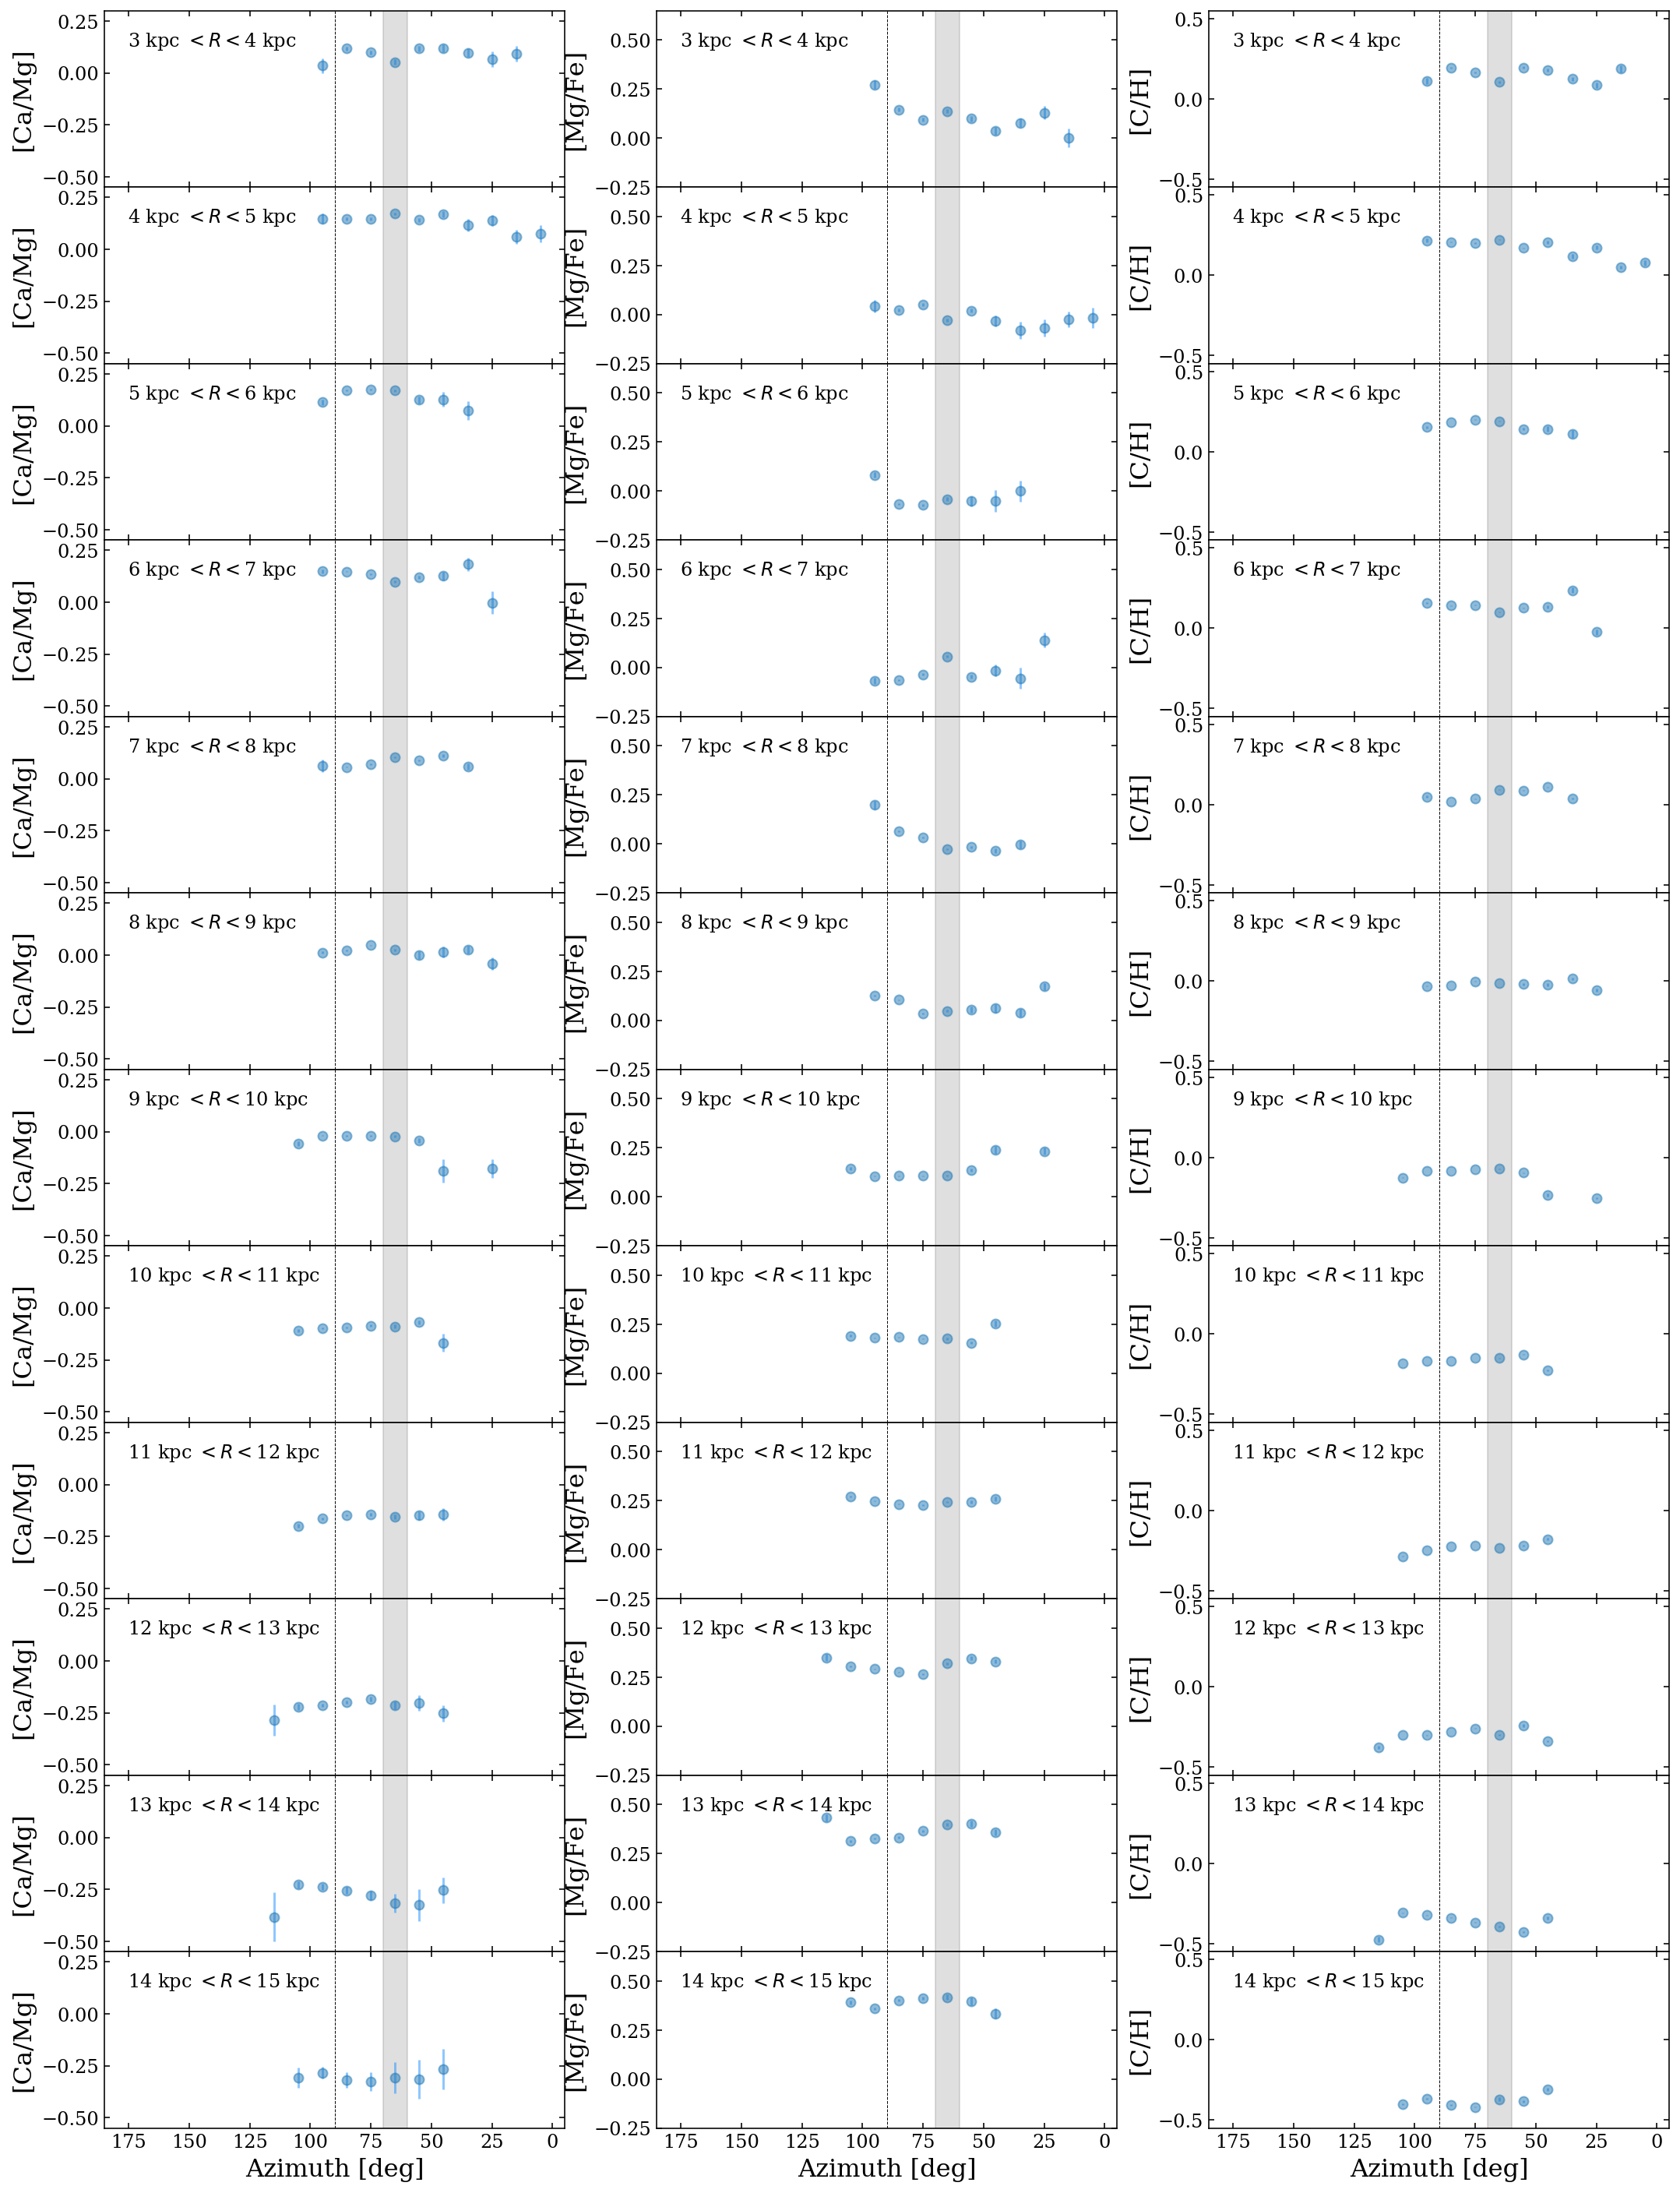

In [35]:
chems = np.array([     fe  , nafe , mnfe , camg , mgfe , c  ])
chem_errs = np.array([ sfe , snafe, smnfe, scamg, smgfe, sc ])
chem_mins = np.array([ -0.4, -0.2 , -0.2, -0.5 , -0.2 , -0.5])
chem_maxs = np.array([ 0.4 , 0.3  , 0.15 , 0.25 , 0.6  , 0.5 ])
chem_names = np.array(['[Fe/H]','[Na/Fe]','[Mn/Fe]','[Ca/Mg]','[Mg/Fe]','[C/H]'])

R_bin_size = 1 # kpc
R_min = 3 # kpc
R_max = 15 # kpc
n_az_bins = 18

# Declare the R range
R_range = np.arange(R_min, R_max, R_bin_size)
n_R_bins = len(R_range)

# Declare az range
az_range = np.linspace(0, 180, n_az_bins, endpoint=False)
az_bin_size = 180/n_az_bins
az_range_cents = az_range+(az_bin_size/2)

# Determine how to structure the figures
n_abund_remain = len(chems)
n_abund_complete = 0
n_figs = math.ceil(n_abund_remain / 3)

# Calculate the az coordinate which will be used
gc_az = np.arctan2(-gc_x, gc_y)*180/np.pi

# Loop over the number of figures
for i in range( n_figs ):
    
    n_this_fig = np.min([n_abund_remain,3])
    
    # Make the figure
    fig = plt.figure( figsize=(int(n_this_fig*6),25) )
    axs = fig.subplots( nrows=n_R_bins, ncols=n_this_fig )

    # Now loop over each abundance: 
    for ii in range(n_this_fig):
        
        # Get the data
        this_abund = chems[ int(ii+n_abund_complete) ]
        this_abund_err = chem_errs[ int(ii+n_abund_complete) ]
        
        # Now loop over each radius and plot the azimuth
        for j in range(n_R_bins):

            # There will be n_az_bins averages and errors
            this_abund_avg = np.zeros(n_az_bins)
            this_abund_avg_err = np.zeros(n_az_bins)
            
            # Now loop over each azimuth
            for jj in range(n_az_bins):
                
                # Determine which stars lie in this range
                where_these_stars = np.where(   (gc_az > az_range[jj]   ) &
                                                (gc_az < (az_range[jj]+az_bin_size) ) &
                                                (gc_R > R_range[j]   ) &
                                                (gc_R < (R_range[j]+R_bin_size) ) )[0]
                
                if len(where_these_stars) < 5:
                    this_abund_avg[jj] = -9999
                    this_abund_avg_err[jj] = 0
                    continue
                
                # Calculate the mean of the abundance
                this_abund_avg[jj] = log_avg( this_abund[where_these_stars] )
                this_abund_avg_err[jj] = log_mean_err(  this_abund[where_these_stars], 
                                                        this_abund_err[where_these_stars]
                                                     )
                
            ##jj
            
            # Now plot
            axs[j,ii].errorbar( az_range_cents, this_abund_avg, yerr=this_abund_avg_err, fmt='o', 
                                ecolor='DodgerBlue', alpha=0.5)
            axs[j,ii].set_ylabel(chem_names[ int(ii+n_abund_complete) ])
            axs[j,ii].set_ylim(chem_mins[ int(ii+n_abund_complete) ]-0.05, chem_maxs[ int(ii+n_abund_complete) ]+0.05)
            axs[j,ii].set_xlim(-5, 185)
            axs[j,ii].invert_xaxis()
            axs[j,ii].annotate( str(int(R_range[j]))+r' kpc $<R<$'+str(int(R_range[j]+R_bin_size))+' kpc', 
                                xy=(0.05,0.8), xycoords='axes fraction', fontsize=12)
            axs[j,ii].axvline(90, linestyle='dashed', linewidth=0.5, color='Black')
            axs[j,ii].fill_betweenx([-10,10], [70,70], [60,60], facecolor='Grey', edgecolor='Grey', alpha=0.25)
            
            if j != (n_R_bins-1):
                axs[j,ii].tick_params(labelbottom='off')
            else:
                axs[j,ii].set_xlabel('Azimuth [deg]')
            ##ie
            
        ###j
    ##ii
    fig.subplots_adjust(hspace=0)
    fig.savefig('chem_plots'+str(i)+'.pdf')
    plt.show()
    plt.close('all')
    
    n_abund_complete+=n_this_fig
    n_abund_remain-=n_this_fig
###i
    
# No output
pass; 

# End